In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.datasets as datasets
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from torchaudio.datasets import LIBRISPEECH

from dataset_SpecAugment import MyPipeline, LibriSpeechWav2Vec
from wav2vec import (
    Wav2Vec,
    ContrastiveLoss
)
import wandb
from tqdm import tqdm

### Dataset

Total num of .flac: 2703
Max len and min len of .flac (sec * 16000) 522320 23120


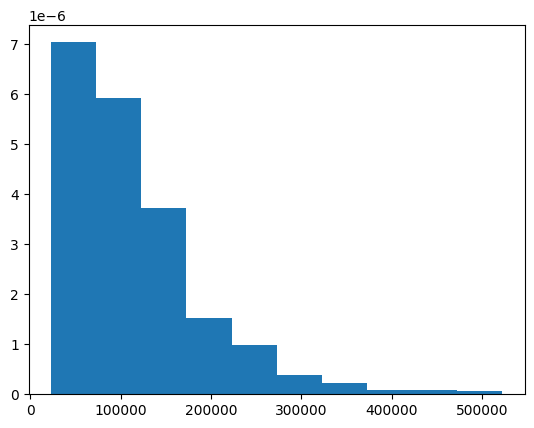

In [2]:
data = datasets.LIBRISPEECH("data", url="dev-clean",)
samples = []
lens = []
for i in range(2800):
    try:
        samples.append(data.__getitem__(i))
        lens.append(data.__getitem__(i)[0].shape[1])
    except IndexError as err:
        break

num = len(samples)

print("Total num of .flac:", num)
print("Max len and min len of .flac (sec * 16000)", max(lens), min(lens))
plt.hist(lens, density=True)
plt.show()
arr = np.array(lens)

### Config wandb

In [3]:
wandb.init(project='Wav2Vec')
config = {
    'depthwise_conv_kernel_size':3,
    'num_heads':8,
    'num_conformers':4,
    'mask_ratio':0.05,
    'distraction_ratio':0.05,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 128,
    'input_dim': 128,
    'embedding_dim': 64,
    'temperature':0.5,
    'dataset': "LibriSpeech dev-clean",
}
torch.autograd.set_detect_anomaly(True)
wandb.config.update(config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: roman-kuznetsov (roman-kuznetsov-bmstu-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
dataset = LibriSpeechWav2Vec("data",
                             url="dev-clean",
                             max_length=int(arr.mean()
                                            + arr.std() * 3
                                            ),
                             n_mel=config['input_dim'],)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloader = torch.utils.data.DataLoader(dataset,
                                         shuffle=True,
                                         batch_size=config["batch_size"],)
print(device)

In [5]:
print(int(arr.mean() + arr.std() * 3))

340160


### Model

In [19]:
model = Wav2Vec(input_dim=config["input_dim"],
                embed_dim=config['embedding_dim'],
                ffn_dim=config['embedding_dim'], 
                depthwise_conv_kernel_size=config['depthwise_conv_kernel_size'],
                num_heads=config['num_heads'],
                num_conformers=config['num_conformers'],
                mask_ratio=config['mask_ratio'],
                distraction_ratio=config['distraction_ratio'],)
model = model.to(device)
criterion = ContrastiveLoss(temperature=config['temperature'])
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

### Training

In [20]:
warmup_epochs = 3
warmup_factor = 0.2

best_loss = float("inf")
patience = 5
no_improve_epochs = 0

for epoch in range(config["epochs"]):
    model.train()
    epoch_loss = 0.0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=False)

    # Warmup lr manually
    if epoch < warmup_epochs:
        warmup_lr = config["learning_rate"] * (warmup_factor + (1 - warmup_factor) * (epoch / warmup_epochs))
        for param_group in optimizer.param_groups:
            param_group["lr"] = warmup_lr

    for x, lengths in pbar:
        x, lengths = x.to(device), lengths.to(device)
        optimizer.zero_grad()

        c, y_t, y_distraction = model(x, lengths)
        loss = criterion(c, y_t, y_distraction)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    # Шедулер обновляется по epoch
    scheduler.step()

    avg_loss = epoch_loss / len(dataloader)
    wandb.log({
        "loss": avg_loss,
        "learning_rate": optimizer.param_groups[0]["lr"],
        "epoch": epoch
    })
    print(f"Epoch {epoch + 1} - Avg Loss: {avg_loss:.4f}")

    # Early stopping & best model saving
    if avg_loss < best_loss:
        best_loss = avg_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), f"{wandb.run.dir}/BestModel.pt")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping triggered.")
            break

wandb.finish()

Epoch 1 - Avg Loss: 3.2621


Epoch 2 - Avg Loss: 3.1176


Epoch 3 - Avg Loss: 3.0711


Epoch 4 - Avg Loss: 3.0444


Epoch 5 - Avg Loss: 3.0395


Epoch 6 - Avg Loss: 3.0391


Epoch 7 - Avg Loss: 3.0377


Epoch 8 - Avg Loss: 3.0255


Epoch 9 - Avg Loss: 3.0286


Epoch 10 - Avg Loss: 2.9927


Epoch 11 - Avg Loss: 2.9980


Epoch 12 - Avg Loss: 3.0219


Epoch 13 - Avg Loss: 2.9893


Epoch 14 - Avg Loss: 2.9462


Epoch 15 - Avg Loss: 2.9833


Epoch 16 - Avg Loss: 3.0330


Epoch 17 - Avg Loss: 2.9848


Epoch 18 - Avg Loss: 3.0340


Epoch 19 - Avg Loss: 2.9893
Early stopping triggered.


epoch,▁▁▂▂▃▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
learning_rate,▇▆▃▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▇▇███▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,18
learning_rate,0.0009
loss,2.98927


In [21]:
torch.save(model.state_dict(), f"best_models/wav2vec/NewModel2.pt")